In [3]:
# Import required libraries 
import tensorflow as tf
import pandas as pd
from IPython.display import YouTubeVideo
import requests
import os
import subprocess
import random
import glob

In [4]:
# Constants
folder_path = '../2/frame/train'                                      # Folder path where Youtube-8M dataset will be saved. 
url = 'https://research.google.com/youtube8m/csv/2/vocabulary.csv' # vocabulary.csv will be downloaded from this location.
local_filename = 'vocabulary.csv'                                  # The filename under which the downloaded file will be saved locally.
server_location = 'us'                                             # Specifies the geographical region or server mirror to optimize download speed. Choose from 'us' for United States, 'eu' for Europe, or 'asia' for Asia.
shard_no = 1                                                       # The shard no of dataset to be downloaded. (Total 100 Shards)

In [5]:
def create_folder(folder_path):
    """
    Creates a folder/directory at the specified path if it doesn't already exist.

    Parameters:
    - folder_path (str): The path where the new folder will be created.

    Returns:
    - return True/False, whether the folder is created successfully or not.
    """
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Directory '{folder_path}' created successfully.")
            return True
        except OSError as e:
            print(f"Error: Creating directory '{folder_path}' failed. {e}")
            return False
    else:
        print(f"Directory '{folder_path}' already exists.")
        return False

In [6]:
def download_dataset(folder_path, shard_no, server_location):
    """
    Downloads first shard(1/100th) of Youtube-8M dataset inside folder_path location.

    Parameters:
    - folder_path (str)    : The path where the datset will be downloaded.
    - shard_no (int)       : The shard number of the dataset to be downloaded. 
    - server_location (str): Specifies the geographical region or server mirror to optimize download speed.
      Choose from 'us' for United States, 'eu' for Europe, or 'asia' for Asia.
    """
    if not create_folder(folder_path):
        return
    currentDir = os.getcwd()
    %cd {folder_path}
    !curl data.yt8m.org/download.py | shard={shard_no},100 partition=2/frame/train mirror={server_location} python
    %cd {currentDir}

In [7]:
download_dataset(folder_path, shard_no, server_location)

Directory '../2/frame/train' already exists.


In [6]:
# Select a random tfrecord file from {folder_path}
records_path = random.choice(glob.glob(os.path.join(folder_path, '*.tfrecord')))

In [8]:
print(records_path)

2/frame/train/train0979.tfrecord


In [9]:
vid_ids = [] # This array stores the video IDs extracted from the TFRecord file.
labels = []  # This array stores the label_ids associated with each video. The label ids are mapped to label names through vocabulary.csv which is discussed later. 
rgb = []     # This array stores the RGB features extracted from the TFRecord file.
audio = []   # This array stores the audio features extracted from the TFRecord file. 

## Format of Frame-level features @Yt8m
```
Frame-level features are stored as tensorflow.SequenceExample protocol buffers. A tensorflow.SequenceExample proto is reproduced here in text format:
context: {
  feature: {
    key  : "id"
    value: {
      bytes_list: {
        value: (Video id)
      }
    }
  }
  feature: {
    key  : "labels"
      value: {
        int64_list: {
          value: [1, 522, 11, 172]  # label list
        }
      }
    }
}

feature_lists: {
  feature_list: {
    key  : "rgb"
    value: {
      feature: {
        bytes_list: {
          value: [1024 8bit quantized features]
        }
      }
      feature: {
        bytes_list: {
          value: [1024 8bit quantized features]
        }
      }
      ... # Repeated for every second, up to 300
  }
  feature_list: {
    key  : "audio"
    value: {
      feature: {
        bytes_list: {
          value: [128 8bit quantized features]
        }
      }
      feature: {
        bytes_list: {
          value: [128 8bit quantized features]
        }
      }
    }
    ... # Repeated for every second, up to 300
  }

}
```

In [10]:
def decode_quantized_features(features):
    """
    Decodes the quantized RGB or audio features from a TFRecord.

    Parameters:
    - features: A TensorFlow Feature object containing quantized data (bytes).

    Returns:
    - Decoded features as TensorFlow tensors of type tf.uint8.
    """
    return tf.io.decode_raw(features, tf.uint8)


# Iterate over each record in the TFRecord file specified by records_path
for record in tf.compat.v1.python_io.tf_record_iterator(records_path):
    # Parse the SequenceExample from the binary record data
    seq_example = tf.train.SequenceExample.FromString(record)

    # Extract the video_id and labels
    vid_ids.append(seq_example.context.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(seq_example.context.feature['labels'].int64_list.value)

    # lists to store frame-level features
    rgb_features = []
    audio_features = []
    
    # Iterate over each frame-level feature pair (RGB and audio) in the SequenceExample
    for rgb_feature, audio_feature in zip(seq_example.feature_lists.feature_list['rgb'].feature,
                                           seq_example.feature_lists.feature_list['audio'].feature):
        
        # Decode the quantized RGB features and audio features
        decoded_rgb = decode_quantized_features(rgb_feature.bytes_list.value[0])     
        decoded_audio = decode_quantized_features(audio_feature.bytes_list.value[0]) 

        rgb_features.append(decoded_rgb)
        audio_features.append(decoded_audio)
    
    # Append frame level list to main list 
    rgb.append(rgb_features)
    audio.append(audio_features)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [11]:
print('Number of videos in this tfrecord: ',len(vid_ids))
print ('Number of labels in this tfrecord: ', len (labels))
print('Picking a youtube video id:',vid_ids[15])

Number of videos in this tfrecord:  1043
Number of labels in this tfrecord:  1043
Picking a youtube video id: 3qpX


In [12]:
print(vid_ids[:10])

['XfpX', '5LpX', 'ebpX', 'C9pX', 'mvpX', 'ropX', 'SupX', 'WNpX', 'HcpX', 'WApX']


In [13]:
print(labels[:10])

[[2, 30, 280, 1178], [82, 103, 350], [2, 7, 171, 174, 361, 1549], [5, 16, 150, 204], [12, 195, 237, 342], [3], [43, 1032], [1196], [0, 1], [106]]


In [14]:
print(len(rgb[0]))

213


In [15]:
print(rgb[0])

[<tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([  0,  88, 176, ..., 135, 174, 141], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([149,  99,  74, ...,  80, 130,  68], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([110,  69,  74, ..., 155, 195, 156], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([ 96,  93,  85, ..., 192, 159,  53], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([175, 181,  81, ..., 140, 137, 128], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([133, 206, 108, ...,  91, 203, 168], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([133, 202, 101, ...,  99, 255, 114], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([190, 190, 100, ...,  90, 165, 127], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([ 94, 195, 115, ...,  90, 255, 156], dtype=uint8)>, <tf.Tensor: shape=(1024,), dtype=uint8, numpy=array([ 67, 204, 

In [16]:
print(rgb[0][10])

tf.Tensor([ 61 207 103 ... 149  81  89], shape=(1024,), dtype=uint8)


- Here, the youtube video id: 'k6bX' of the dataset maps to "cEoT60kT4dM".

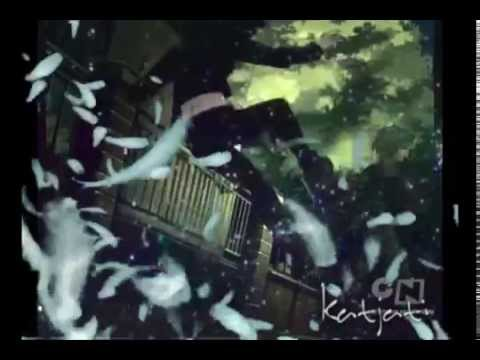

In [18]:
YouTubeVideo("cEoT60kT4dM")

### The label ids are mapped to label names through vocabulary.csv 

In [23]:
def download_file(url, local_filename):
    """
    Downloads a file from the specified URL and saves it locally.

    Parameters:
    - url (str): The URL from which the file will be downloaded.
    - local_filename (str): The filename under which the downloaded file will be saved locally.
    """
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        print(f"Download completed. Script saved as {local_filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error occurred: {e}")

In [24]:
download_file(url, local_filename)

Download completed. Script saved as vocabulary.csv


In [25]:
vocabulary = pd.read_csv('vocabulary.csv')

In [26]:
vocabulary.head()

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,0,788288,/m/03bt1gh,Game,https://en.wikipedia.org/wiki/Game,Games,NaN,NaN,"A game is structured form of play, usually und..."
1,1,539945,/m/01mw1,Video game,https://en.wikipedia.org/wiki/Video_game,Games,NaN,NaN,A video game is an electronic game that involv...
2,2,415890,/m/07yv9,Vehicle,https://en.wikipedia.org/wiki/Vehicle,Autos & Vehicles,NaN,NaN,A vehicle is a mobile machine that transports ...
3,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,NaN,NaN,A concert is a live music performance in front...
4,4,286532,/m/09jwl,Musician,https://en.wikipedia.org/wiki/Musician,Arts & Entertainment,NaN,NaN,A musician is a person who plays a musical ins...


In [27]:
vocabulary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Index             3862 non-null   int64 
 1   TrainVideoCount   3862 non-null   int64 
 2   KnowledgeGraphId  3862 non-null   object
 3   Name              3806 non-null   object
 4   WikiUrl           3806 non-null   object
 5   Vertical1         3862 non-null   object
 6   Vertical2         584 non-null    object
 7   Vertical3         32 non-null     object
 8   WikiDescription   3806 non-null   object
dtypes: int64(2), object(7)
memory usage: 271.7+ KB


In [28]:
vocabulary.describe()

,Index,TrainVideoCount
count,3862.000000,3862.000000
mean,1930.500000,3032.527188
std,1115.007698,21182.048375
min,0.000000,123.000000
25%,965.250000,234.000000
50%,1930.500000,440.500000
75%,2895.750000,1199.750000
max,3861.000000,788288.000000


In [29]:
print(vocabulary.iloc[316]) # Television Advertisement

Index                                                             315
TrainVideoCount                                                  4898
KnowledgeGraphId                                            /m/018ng8
Name                                         Television advertisement
WikiUrl             https://en.wikipedia.org/wiki/Television_adver...
Vertical1                                        Arts & Entertainment
Vertical2                                                         NaN
Vertical3                                                         NaN
WikiDescription     A television advertisement is a span of televi...
Name: 316, dtype: object
